# Web Server Log Analysis with Apache Spark

Description: This project will demonstrate how to perform web server log analysis with Apache Spark. 

Spark allows you to store your logs in files on disk cheaply, while still providing a quick and simple way to
perform data analysis on them. 

This project will show how to use Spark on a real-world text-based production logs and harness the power of that data.

Log data comes from many sources, such as web, file, compute servers, 
application logs, user-generated content.

Some use cases of log data: -
1. Improving business and customer intelligence
2. Building Recommendation Systems
3. Fraud Detection
4. Monitoring servers

# Part 1: Apache Web Server Log file format

#### The log files that we use for this assignment are in the Apache Common Log Format (CLF). The log file entries produced in CLF will look something like this:

CLF -> http://httpd.apache.org/docs/1.3/logs.html#common

127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839

Each part of this log entry is described below.

- 127.0.0.1 ####This is the IP address (or host name, if available) of the client (remote host) which made the request to the server.

- \- ####The "hyphen" in the output indicates that the requested piece of information (user identity from remote machine) is not available.

- \- ####The "hyphen" in the output indicates that the requested piece of information (user identity from local logon) is not available.

- [01/Aug/1995:00:00:01 -0400] ####The time that the server finished processing the request. The format is: [day/month/year:hour:minute:second timezone]

    - ####day = 2 digits
    - ####month = 3 letters
    - ####year = 4 digits
    - ####hour = 2 digits
    - ####minute = 2 digits
    - ####second = 2 digits
    - ####zone = (+ | -) 4 digits

- "GET /images/launch-logo.gif HTTP/1.0" ####This is the first line of the request string from the client. It consists of a three components: the request method (e.g., GET, POST, etc.), the endpoint (a Uniform Resource Identifier), and the client protocol version.

- 200 ####This is the status code that the server sends back to the client. This information is very valuable, because it reveals whether the request resulted in a successful response (codes beginning in 2), a redirection (codes beginning in 3), an error caused by the client (codes beginning in 4), or an error in the server (codes beginning in 5). The full list of possible status codes can be found in the HTTP specification (RFC 2616 section 10).

- 1839 ####The last entry indicates the size of the object returned to the client, not including the response headers. If no content was returned to the client, this value will be "-" (or sometimes 0).

#### Note that log files contain information supplied directly by the client, without escaping. Therefore, it is possible for malicious clients to insert control-characters in the log files, so care must be taken in dealing with raw logs

# NASA-HTTP Web Server Log

#### For this assignment, we will use a data set from NASA Kennedy Space Center WWW server in Florida. The full data set is freely available (http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html) and contains two month's of all HTTP requests. We are using a subset that only contains several days worth of requests.

#### (1a) Parsing Each Log Line
Using the CLF as defined above, we create a regular expression pattern to extract the nine fields of the log line using the Python regular expression search function. The function returns a pair consisting of a Row object and 1. If the log line fails to match the regular expression, the function returns a pair consisting of the log line string and 0. A '-' value in the content size field is cleaned up by substituting it with 0. The function converts the log line's date string into a Python datetime object using the given parse_apache_time function

In [2]:
import re
import datetime

from pyspark.sql import Row


def parse_apache_time(timestamp):
    # Convert Apache timestamp format into a Python datetime object
    month_map = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 
           'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
    # year -> timestamp[7:11]
    # month -> timestamp[3:6]
    # day -> timestamp[0:2]
    # hour -> timestamp[12:14]
    # minute -> timestamp[15:17]
    # second -> timestamp[18:20]
    return datetime.datetime(int(timestamp[7:11]),
                            month_map[timestamp[3:6]],
                            int(timestamp[0:2]),
                            int(timestamp[12:14]),
                            int(timestamp[15:17]),
                            int(timestamp[18:20]))



def parse_apache_log_line(logLine):
    # Parse a line in the Apache log Format and
    # return a dictionary containing the parts of the Apache Access Log and 1,
                                    # or the original invalid log line and 0.
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logLine)
    if match is None:
        return (logLine, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = float(0)
    else:
        size = float(match.group(9))
    return (Row(
        host          =    match.group(1),
        client_id     =    match.group(2),
        user_id       =    match.group(3),
        date_time     =    parse_apache_time(match.group(4)),
        method        =    match.group(5),
        endpoint      =    match.group(6),
        protocol      =    match.group(7),
        response_code =    int(match.group(8)),
        content_size  =    size
    ), 1)


    

In [3]:
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

In [4]:
logLine = '199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245'
parse_apache_log_line(logLine)

(Row(client_id='-', content_size=6245.0, date_time=datetime.datetime(1995, 7, 1, 0, 0, 1), endpoint='/history/apollo/', host='199.72.81.55', method='GET', protocol='HTTP/1.0', response_code=200, user_id='-'),
 1)

### (1b) Configuration and Initial RDD Creation

#### We are ready to specify the input log file and create an RDD containing the parsed log file data. The log file has already been downloaded for you.

#### To create the primary RDD that we'll use in the rest of this assignment, we first load the text file using sc.textfile(logFile) to convert each line of the file into an element in an RDD.

#### Next, we use map(parseApacheLogLine) to apply the parse function to each element (that is, a line from the log file) in the RDD and turn each line into a pair Row object.

#### Finally, we cache the RDD in memory since we'll use it throughout this notebook.

In [5]:
import sys
import os


baseDir = os.getcwd()
path = os.path.join(baseDir, 'NASA_access_log_july95')

def parseLogs():
    # Read and parse log file
    parsed_logs = (sc.textFile(path).map(parse_apache_log_line).cache())
    
    access_logs = (parsed_logs.filter(lambda s:s[1] == 1).map(lambda s: s[0]).cache())
    
    failed_logs = (parsed_logs.filter(lambda s:s[1] == 0).map(lambda s: s[0]).cache())
    
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print("Number of invalid log lines: %d", failed_logs_count)
        for line in failed_logs.take(20):
            print("Invalid log line: %s", line)
    
    print('Read %d lines, successfully parsed %d lines, failed to parse %d lines', 
          parsed_logs.count(), access_logs.count(), failed_logs.count())
    return parsed_logs, access_logs, failed_logs

parsed, access, failed = parseLogs()

Number of invalid log lines: %d 864
Invalid log line: %s 204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html                                                 hqpao/hqpao_home.html HTTP/1.0" 200 1502
Invalid log line: %s nccse.gsfc.nasa.gov - - [01/Jul/1995:07:36:13 -0400] "GET /shuttle/missions/missions.html Shuttle Launches from Kennedy Space Center HTTP/1.0" 200 8677
Invalid log line: %s ix-nbw-nj1-22.ix.netcom.com - - [01/Jul/1995:10:42:09 -0400] "GET /finger @net.com HTTP/1.0" 404 -
Invalid log line: %s gpotterpc.llnl.gov - - [01/Jul/1995:22:26:51 -0400] "GET /htbin/wais.pl?orbit sts71 HTTP/1.0" 200 317
Invalid log line: %s wxs6-7.worldaccess.nl - - [02/Jul/1995:08:09:27 -0400] "GET / /   HTTP/1.0" 200 7074
Invalid log line: %s wxs6-7.worldaccess.nl - - [02/Jul/1995:08:11:20 -0400] "GET / /facts/facts.html HTTP/1.0" 200 7074
Invalid log line: %s s29.abqslip.indirect.com - - [02/Jul/1995:14:24:26 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 7020
Invalid

#### 1c) Data Cleaning
Notice that there are a large number of log lines that failed to parse.

Examine the sample of invalid lines and compare them to the correctly parsed line, an example is included below. 
Based on your observations, alter the APACHE_ACCESS_LOG_PATTERN regular expression below so that the failed lines will correctly parse, and press Shift-Enter to rerun parseLogs().

127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839

In [6]:
# This was originally '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'
APACHE_ACCESS_LOG_PATTERN ='^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

parsed_logs, access_logs, failed_logs = parseLogs()

Number of invalid log lines: %d 849
Invalid log line: %s 204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html                                                 hqpao/hqpao_home.html HTTP/1.0" 200 1502
Invalid log line: %s nccse.gsfc.nasa.gov - - [01/Jul/1995:07:36:13 -0400] "GET /shuttle/missions/missions.html Shuttle Launches from Kennedy Space Center HTTP/1.0" 200 8677
Invalid log line: %s ix-nbw-nj1-22.ix.netcom.com - - [01/Jul/1995:10:42:09 -0400] "GET /finger @net.com HTTP/1.0" 404 -
Invalid log line: %s gpotterpc.llnl.gov - - [01/Jul/1995:22:26:51 -0400] "GET /htbin/wais.pl?orbit sts71 HTTP/1.0" 200 317
Invalid log line: %s wxs6-7.worldaccess.nl - - [02/Jul/1995:08:09:27 -0400] "GET / /   HTTP/1.0" 200 7074
Invalid log line: %s wxs6-7.worldaccess.nl - - [02/Jul/1995:08:11:20 -0400] "GET / /facts/facts.html HTTP/1.0" 200 7074
Invalid log line: %s s29.abqslip.indirect.com - - [02/Jul/1995:14:24:26 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 7020
Invalid

## Part 2: Sample Analyses on the Web Server Log File

#### Now that we have an RDD containing the log file as a set of Row objects, we can perform various analyses.

#### (2a) Example: Content Size Statistics
    
#### Let's compute some statistics about the sizes of content being returned by the web server. In particular, we'd like to know what are the average, minimum, and maximum content sizes.

#### We can compute the statistics by applying a map to the access_logs RDD. The lambda function we want for the map is to extract the content_size field from the RDD. The map produces a new RDD containing only the content_sizes (one element for each Row object in the access_logs RDD). To compute the minimum and maximum statistics, we can use min() and max() functions on the new RDD. We can compute the average statistic by using the reduce function with a lambda function that sums the two inputs, which represent two elements from the new RDD that are being reduced together. The result of the reduce() is the total content size from the log and it is to be divided by the number of requests as determined using the count() function on the new RDD.

In [7]:
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print("Content Size Avg: %i, Min: %i, Max: %s" %(
        content_sizes.reduce(lambda a,b: a+b) / content_sizes.count(),
        content_sizes.min(),
        content_sizes.max()
))

Content Size Avg: 20464, Min: 0, Max: 6823936.0


#### (2b) Example: Response Code Analysis
#### Next, lets look at the response codes that appear in the log. As with the content size analysis, first we create a new RDD by using a lambda function to extract the response_code field from the access_logs RDD. The difference here is that we will use a pair tuple instead of just the field itself. Using a pair tuple consisting of the response code and 1 will let us count how many records have a particular response code. Using the new RDD, we perform a reduceByKey function. reduceByKey performs a reduce on a per-key basis by applying the lambda function to each element, pairwise with the same key. We use the simple lambda function of adding the two values. Then, we cache the resulting RDD and create a list by using the take function.


In [8]:
response_codes = access_logs.map(lambda log: (log.response_code, 1))
response_codes = response_codes.reduceByKey(lambda x, y: x+y).cache()
response_code_count_pairs = response_codes.collect()
response_code_count_pairs

[(302, 46569),
 (304, 132626),
 (500, 62),
 (200, 1700757),
 (403, 54),
 (501, 14),
 (404, 10784)]

#### 2c) Example: Response Code Graphing with matplotlib
#### Now, lets visualize the results from the last example. We can visualize the results from the last example using matplotlib. First we need to extract the labels and fractions for the graph. We do this with two separate map functions with a lambda functions. The first map function extracts a list of of the response code values, and the second map function extracts a list of the per response code counts divided by the total size of the access logs. Next, we create a figure with figure() constructor and use the pie() method to create the pie plot.

In [9]:
response_code_values = response_codes.map(lambda code_count_pair: code_count_pair[0]).collect()
count = access_logs.count()
fractions = response_codes.map(lambda codeCountPair: (float(codeCountPair[1])/count)).collect()
print(response_code_values)
print(fractions)

[302, 304, 500, 200, 403, 501, 404]
[0.02462839778175714, 0.07014034839063159, 3.278920875408411e-05, 0.8994592953704811, 2.8558343108395834e-05, 7.404014879954476e-06, 0.00570320689038779]


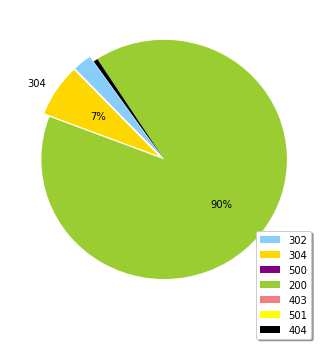

In [11]:
import matplotlib.pyplot as plt

def pie_pct_format(value):
    # Determine the appropriate format string for the pie chart percentage label
    return '' if value < 7 else '%.0f%%' %value

figure = plt.figure(figsize=(5.5, 5.5))
colors = ['lightskyblue', 'gold', 'purple', 'yellowgreen', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fractions, labels=response_code_values, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(response_code_values, loc=(0.80, -0.1), shadow=True)
pass

## (2d) Example: Frequent Hosts
### Let's look at hosts that have accessed the server multiple times (e.g., more than ten times). As with the response code analysis in (2b), first we create a new RDD by using a lambda function to extract the host field from the access_logs RDD using a pair tuple consisting of the host and 1 which will let us count how many records were created by a particular host's request. Using the new RDD, we perform a reduceByKey function with a lambda function that adds the two values. We then filter the result based on the count of accesses by each host (the second element of each pair) being greater than ten. Next, we extract the host name by performing a map with a lambda function that returns the first element of each pair. Finally, we extract 20 elements from the resulting RDD - note that the choice of which elements are returned is not guaranteed to be deterministic.

In [12]:
frequentHostsRDD = access_logs.map(lambda log: (log.host, 1))
hostSum = frequentHostsRDD.reduceByKey(lambda a,b: a+b)

hostMoreThan10 = hostSum.filter(lambda s: s[1]>10)

hostsPick20 = (hostMoreThan10.map(lambda s: s[0]).take(20))

print("Any 20 hosts that have accessed more than 10 times: %s", hostsPick20)

Any 20 hosts that have accessed more than 10 times: %s ['unicomp6.unicomp.net', '129.94.144.152', 'slip1.yab.com', 'dd14-046.compuserve.com', 'teleman.pr.mcs.net', 'isdn6-34.dnai.com', 'citynet.ci.la.ca.us', 'wwwproxy.info.au', '204.19.123.36', 'piweba1y.prodigy.com', 'leet.cts.com', 'www-b2.proxy.aol.com', 'ppp5.earthlight.co.nz', 'ppp6.cpbx.net', 'blv-pm2-ip16.halcyon.com', 'ana0013.deltanet.com', '131.128.2.155', 'indy2.indy.net', 'ad08-027.compuserve.com', 'pma02.rt66.com']


## (2e) Example: Visualizing Endpoints
#### Now, lets visualize the number of hits to endpoints (URIs) in the log. To perform this task, we first create a new RDD by using a lambda function to extract the endpoint field from the access_logs RDD using a pair tuple consisting of the endpoint and 1 which will let us count how many records were created by a particular host's request. Using the new RDD, we perform a reduceByKey function with a lambda function that adds the two values. We then cache the results.
#### Next we visualize the results using matplotlib. We previously imported the matplotlib.pyplot library, so we do not need to import it again. We perform two separate map functions with lambda functions. The first map function extracts a list of endpoint values, and the second map function extracts a list of the visits per endpoint values. Next, we create a figure with figure() constructor, set various features of the plot (axis limits, grid lines, and labels), and use the plot() method to create the line plot.

In [13]:
endpointsRDD = access_logs.map(lambda log: (log.endpoint, 1))
endpoints_count_map = endpointsRDD.reduceByKey(lambda x,y: x+y).cache()
# endpoints_count_map = endpoints_count_map.map(lambda x[1]: -1*x[1])

In [14]:
count = access_logs.count()
endpoints = endpoints_count_map.map(lambda x: x[0]).collect()
endpoints_fractions = endpoints_count_map.map(lambda endpoint_count: (float(endpoint_count[1]/count))).collect()

endpoints_counts = endpoints_count_map.map(lambda endpoint_count: endpoint_count[1]).collect()


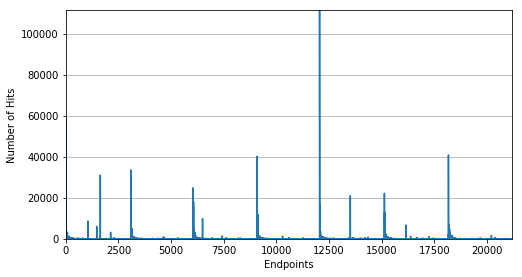

In [15]:
endpoints_fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(endpoints), 0, max(endpoints_counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(endpoints_counts)
pass

### (2f) Example: Top Endpoints
#### For the final example, we'll look at the top endpoints (URIs) in the log. To determine them, we first create a new RDD by using a lambda function to extract the endpoint field from the access_logs RDD using a pair tuple consisting of the endpoint and 1 which will let us count how many records were created by a particular host's request. Using the new RDD, we perform a reduceByKey function with a lambda function that adds the two values. We then extract the top ten endpoints by performing a takeOrdered with a value of 10 and a lambda function that multiplies the count (the second element of each pair) by -1 to create a sorted list with the top endpoints at the bottom

In [16]:
endpointsEmitted = access_logs.map(lambda log: (log.endpoint, 1))
endpointsReduced = endpointsEmitted.reduceByKey(lambda x, y: x+y)
# endpoints_sorted = endpointsReduced.map(lambda x: (x[0], -1*x[1]))
# sorted(endpoints_sorted.collect(), key = lambda x: x[1])
top_endpoints = endpointsReduced.takeOrdered(10, lambda s: -1 * s[1])
top_endpoints

[('/images/NASA-logosmall.gif', 111331),
 ('/images/KSC-logosmall.gif', 89639),
 ('/images/MOSAIC-logosmall.gif', 60468),
 ('/images/USA-logosmall.gif', 60014),
 ('/images/WORLD-logosmall.gif', 59489),
 ('/images/ksclogo-medium.gif', 58802),
 ('/images/launch-logo.gif', 40871),
 ('/shuttle/countdown/', 40279),
 ('/ksc.html', 40226),
 ('/images/ksclogosmall.gif', 33585)]

## Part 3: Analyzing Web Server Log File
### Now it is turn to perform analyses on web server log files.
### (3a) Exercise: Top Ten Error Endpoints
#### What are the top ten endpoints which did not have return code 200? Create a sorted list containing top ten endpoints and the number of times that they were accessed with non-200 return code.
#### Think about the steps that you need to perform to determine which endpoints did not have a 200 return code, how you will uniquely count those endpoints, and sort the list. You might want to refer Word Count project for insights.

In [17]:
non_200_response_codesRDD = access_logs.filter(lambda log: log.response_code != 200)

non_200_top_enpoints = non_200_response_codesRDD.map(
                        lambda log: (log.endpoint, 1)).reduceByKey(
                        lambda a, b: a+b)

non_200_top_10_endpoints = non_200_top_enpoints.takeOrdered(10, lambda x: -1*x[1])
non_200_top_10_endpoints

[('/images/NASA-logosmall.gif', 21010),
 ('/images/KSC-logosmall.gif', 12435),
 ('/images/MOSAIC-logosmall.gif', 6628),
 ('/images/USA-logosmall.gif', 6577),
 ('/images/WORLD-logosmall.gif', 6413),
 ('/images/ksclogo-medium.gif', 5837),
 ('/images/launch-logo.gif', 4628),
 ('/shuttle/countdown/liftoff.html', 3509),
 ('/shuttle/countdown/', 3345),
 ('/shuttle/countdown/images/cdtclock.gif', 3251)]

### (3b) Exercise: Number of Unique Hosts
#### How many unique hosts are there in the entire log?
#### Think about the steps that you need to perform to count the number of different hosts in the log.

In [18]:
uniqueHosts = access_logs.map(lambda x: (x.host, 1)).reduceByKey(lambda a, b: a+b).cache()
count = uniqueHosts.count()
print(count)
access_logs.count()

81971


1890866

## (3c) Exercise: Number of Unique Daily Hosts
#### For an advanced exercise, let's determine the number of unique hosts in the entire log on a day-by-day basis. This computation will give us counts of the number of unique daily hosts. We'd like a list sorted by increasing day of the month which includes the day of the month and the associated number of unique hosts for that day. Make sure you cache the resulting RDD dailyHosts so that we can reuse it in the next exercise.
#### Think about the steps that you need to perform to count the number of different hosts that make requests each day. Since the log only covers a single month, you can ignore the month.

In [20]:
hosts_day_map = access_logs.map(lambda log: (log.date_time.day, log.host)).groupByKey()
dayHostCount = hosts_day_map.map(lambda x: (x[0],len(set(x[1])))).sortByKey()

dailyHosts = (dayHostCount).cache()
dailyHostsList = dailyHosts.takeOrdered(30)
print('Unique hosts per day: %s', dailyHostsList)


Unique hosts per day: %s [(1, 5192), (2, 4859), (3, 7335), (4, 5522), (5, 7382), (6, 7819), (7, 6473), (8, 2897), (9, 2553), (10, 4464), (11, 4924), (12, 5345), (13, 6951), (14, 5296), (15, 3116), (16, 3012), (17, 4943), (18, 4522), (19, 4918), (20, 4727), (21, 4339), (22, 2575), (23, 2635), (24, 4297), (25, 4376), (26, 4296), (27, 4368), (28, 2175)]


## (3d) Exercise: Visualizing the Number of Unique Daily Hosts
#### Using the results from the previous exercise, use matplotlib to plot a "Line" graph of the unique hosts requests by day.
#### daysWithHosts should be a list of days and hosts should be a list of number of unique hosts for each corresponding day. 

In [27]:
daysWithHosts = dailyHosts.map(lambda x: x[0]).collect()
hosts = dailyHosts.map(lambda x: x[1]).collect()

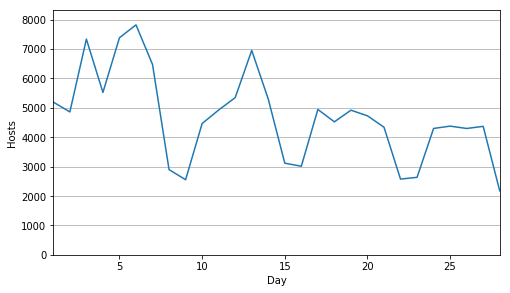

In [28]:
fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(daysWithHosts), max(daysWithHosts), 0, max(hosts)+500])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.plot(daysWithHosts, hosts)
pass

## (3e) Exercise: Average Number of Daily Requests per Hosts
#### Next, let's determine the average number of requests on a day-by-day basis. We'd like a list by increasing day of the month and the associated average number of requests per host for that day. Make sure you cache the resulting RDD avgDailyReqPerHost so that we can reuse it in the next exercise.
#### To compute the average number of requests per host, get the total number of request across all hosts and divide that by the number of unique hosts.
#### Since the log only covers a single month, you can skip checking for the month.
#### Also to keep it simple, when calculating the approximate average use the integer value - you do not need to upcast to float

In [30]:
dayHostCount = hosts_day_map.map(lambda x: (x[0],len(set(x[1])))).sortByKey()

dayAndHostTuple = access_logs.map(lambda x: (x.date_time.day,x.host))

groupedByDay = dayAndHostTuple.groupByKey()

sortedByDay = groupedByDay.sortByKey()

avgDailyReqPerHost = (sortedByDay
                      .map(lambda x: (x[0],len(x[1])/len(set(x[1]))))).cache()

avgDailyReqPerHostList = avgDailyReqPerHost.take(30)
print('Average number of daily requests per Hosts is %s', avgDailyReqPerHostList)

Average number of daily requests per Hosts is %s [(1, 12.463405238828967), (2, 12.401728750771763), (3, 12.207498295841853), (4, 12.756972111553784), (5, 12.811162286643187), (6, 12.91162552756107), (7, 13.472578402595396), (8, 13.41422160856058), (9, 13.81159420289855), (10, 16.31989247311828), (11, 16.310926076360683), (12, 17.255378858746493), (13, 19.270896273917423), (14, 15.880098187311178), (15, 14.610397946084724), (16, 15.885126162018592), (17, 15.168318834715759), (18, 14.211632021229544), (19, 14.789955266368443), (20, 14.08694732388407), (21, 14.894445724821388), (22, 13.691650485436893), (23, 14.874762808349146), (24, 14.952525017454038), (25, 14.327696526508227), (26, 13.697160148975792), (27, 14.119505494505495), (28, 12.468045977011494)]


## (3f) Exercise: Visualizing the Average Daily Requests per Unique Host
### Using the result avgDailyReqPerHost from the previous exercise, use matplotlib to plot a "Line" graph of the average daily requests per unique host by day.
### daysWithAvg should be a list of days and avgs should be a list of average daily requests per unique hosts for each corresponding day.

In [31]:
daysWithAvg = avgDailyReqPerHost.map(lambda x: x[0]).collect()
avgs = avgDailyReqPerHost.map(lambda x: x[1]).collect()

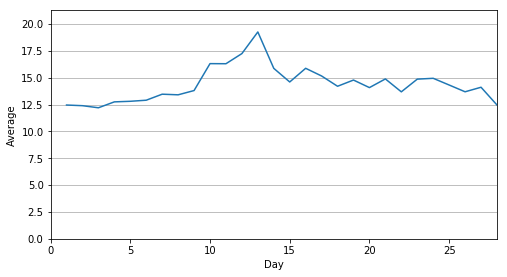

In [32]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithAvg), 0, max(avgs)+2])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Average')
plt.plot(daysWithAvg, avgs)
pass

## Part 4: Exploring 404 Response Codes
#### Let's drill down and explore the error 404 response code records. 404 errors are returned when an endpoint is not found by the server (i.e., a missing page or object).
#### (4a) Exercise: Counting 404 Response Codes
#### Create a RDD containing only log records with a 404 response code. Make sure you cache() the RDD badRecords as we will use it in the rest of this exercise.
#### How many 404 records are in the log?

In [34]:
records_404 = access_logs.filter(lambda log: log.response_code == 404).cache()
records_404.count()

10784

### 4b) Exercise: Listing 404 Response Code Records
#### Using the RDD containing only log records with a 404 response code that you cached in part (4a), print out a list up to 40 distinct endpoints that generate 404 errors - no endpoint should appear more than once in your list.

In [39]:
distinct_endpoints = records_404.map(lambda log: (log.endpoint, 1)).reduceByKey(lambda a, b: a+b).cache()
result = []
# print(distinct_endpoints.collect())
for key, value in distinct_endpoints.take(40):
    result.append(key)
print(result)

['/persons/astronauts/i-to-l/lousmaJR.txt', '/history/apollo-13/apollo-13.html', '/shuttle/technology/images/sts-comm-small.gif', '/Business/', '/misc/showcase/personal_edition/images/milan_banner.gif', '/facts/announce.html', '/shutle/missions/sts-71/mission-sts-71.html', '/shuttle/countdown/images/NASA-logosmall.gi', '/history.history.hrml', '/history/history.hrml', '/mdss/ped/acs/MDSS.html', ':/facilities/tour.html', '/gpc.html', '/history/apollo/apollo-13/apollo-13html', '/persons/astronauts/e-to-h/garriottOK.txt', '/html', '/shuttle/missions/sts-69/\\www.pic.net', '/shuttle/missions/sts-51L', '/shuttle/missions/sts-25/', '/software/winvm', '/shuttle/missions/sts-71/missions-sts-71.html', '/history/apollo/apollo-13/apollo-13-.html', '/pub/winvn/win3/', '/shuttle/missions/cu-show', '/ksc.hmtl', '/11/history/apollo/images/', '/history/apollo/publications/sp-350/sp-350.txt%7E', '/elv/goes_lau.gif', '/images/NASA-lo', '/pub/winvn/win3', '/resources/orbiters/Endeavour.html', '/resources

In [40]:
# An other approach of performing th aboe operation

endpoints_404 = records_404.map(lambda log: log.endpoint)
distinct_endpoints_404 = endpoints_404.distinct()
print("404 URLs:", distinct_endpoints_404.take(40))

404 URLs: ['/persons/astronauts/i-to-l/lousmaJR.txt', '/history/apollo-13/apollo-13.html', '/shuttle/technology/images/sts-comm-small.gif', '/Business/', '/misc/showcase/personal_edition/images/milan_banner.gif', '/facts/announce.html', '/shutle/missions/sts-71/mission-sts-71.html', '/shuttle/countdown/images/NASA-logosmall.gi', '/history.history.hrml', '/history/history.hrml', '/mdss/ped/acs/MDSS.html', ':/facilities/tour.html', '/gpc.html', '/history/apollo/apollo-13/apollo-13html', '/persons/astronauts/e-to-h/garriottOK.txt', '/html', '/shuttle/missions/sts-69/\\www.pic.net', '/shuttle/missions/sts-51L', '/shuttle/missions/sts-25/', '/software/winvm', '/shuttle/missions/sts-71/missions-sts-71.html', '/history/apollo/apollo-13/apollo-13-.html', '/pub/winvn/win3/', '/shuttle/missions/cu-show', '/ksc.hmtl', '/11/history/apollo/images/', '/history/apollo/publications/sp-350/sp-350.txt%7E', '/elv/goes_lau.gif', '/images/NASA-lo', '/pub/winvn/win3', '/resources/orbiters/Endeavour.html', '

#### (4c) Exercise: Listing the Top Twenty 404 Response Code Endpoints
#### Using the RDD containing only log records with a 404 response code that you cached in part (4a), print out a list of the top twenty endpoints that generate the most 404 errors.
#### Remember, top endpoints should be in sorted order

In [43]:
top_20_404_endpoints = distinct_endpoints.takeOrdered(20, lambda x: -1*x[1])
top_20_404_endpoints

[('/pub/winvn/readme.txt', 667),
 ('/pub/winvn/release.txt', 547),
 ('/history/apollo/apollo-13.html', 286),
 ('/shuttle/resources/orbiters/atlantis.gif', 232),
 ('/history/apollo/a-001/a-001-patch-small.gif', 230),
 ('/://spacelink.msfc.nasa.gov', 215),
 ('/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 215),
 ('/images/crawlerway-logo.gif', 214),
 ('/history/apollo/sa-1/sa-1-patch-small.gif', 183),
 ('/shuttle/resources/orbiters/discovery.gif', 180),
 ('/shuttle/missions/sts-68/ksc-upclose.gif', 175),
 ('/shuttle/missions/sts-71/images/KSC-95EC-0916.txt', 168),
 ('/elv/DELTA/uncons.htm', 163),
 ('/history/apollo/publications/sp-350/sp-350.txt~', 140),
 ('/shuttle/missions/technology/sts-newsref/stsref-toc.html', 107),
 ('/shuttle/resources/orbiters/challenger.gif', 92),
 ('/procurement/procurement.htm', 86),
 ('/history/apollo-13/apollo-13.html', 73),
 ('/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 71),
 ('/shuttle/countdown/video/livevideo.

### (4d) Exercise: Listing the Top Twenty-five 404 Response Code Hosts
#### Instead of looking at the endpoints that generated 404 errors, let's look at the hosts that encountered 404 errors. Using the RDD containing only log records with a 404 response code that you cached in part (4a), print out a list of the top twenty-five hosts that generate the most 404 errors.¶

In [49]:
top_25_hosts_with_404 = records_404.map(lambda log: (log.host, 1)).reduceByKey(lambda a,b: a+b).cache()
top_25_hosts = top_25_hosts_with_404.takeOrdered(25, lambda x: -1*x[1])
print("Top 25 hosts that generated 404 response codes: \n", top_25_hosts)

Top 25 hosts that generated 404 response codes: 
 [('hoohoo.ncsa.uiuc.edu', 251), ('jbiagioni.npt.nuwc.navy.mil', 131), ('piweba3y.prodigy.com', 110), ('piweba1y.prodigy.com', 92), ('phaelon.ksc.nasa.gov', 64), ('www-d4.proxy.aol.com', 61), ('piweba4y.prodigy.com', 56), ('monarch.eng.buffalo.edu', 56), ('alyssa.prodigy.com', 54), ('titan02f', 53), ('www-a2.proxy.aol.com', 52), ('www-b4.proxy.aol.com', 48), ('www-b6.proxy.aol.com', 44), ('www-b3.proxy.aol.com', 43), ('tearnest2.stpaul.ncr.com', 42), ('www-b2.proxy.aol.com', 41), ('www-d1.proxy.aol.com', 41), ('www-a1.proxy.aol.com', 38), ('piweba2y.prodigy.com', 38), ('www-d3.proxy.aol.com', 38), ('scooter.pa-x.dec.com', 34), ('proxy.austin.ibm.com', 34), ('www-d2.proxy.aol.com', 33), ('www-b5.proxy.aol.com', 32), ('unotv.unomaha.edu', 31)]


### (4e) Exercise: Listing 404 Response Codes per Day
#### Let's explore the 404 records temporally. Break down the 404 requests by day (cache() the RDD errDateSorted) and get the daily counts sorted by day as a list.
#### Since the log only covers a single month, you can ignore the month in your checks.

In [54]:
dailyCounts = records_404.map(lambda log: (log.date_time.day, 1)).reduceByKey(lambda x,y: x+y)
dailyCounts = dailyCounts.sortByKey().cache()
print("404 Errors by day: \n")
print(dailyCounts.collect())

404 Errors by day: 

[(1, 315), (2, 289), (3, 474), (4, 357), (5, 495), (6, 636), (7, 566), (8, 299), (9, 348), (10, 395), (11, 470), (12, 462), (13, 525), (14, 412), (15, 253), (16, 257), (17, 405), (18, 463), (19, 639), (20, 428), (21, 334), (22, 182), (23, 233), (24, 327), (25, 460), (26, 331), (27, 335), (28, 94)]


### (4f) Exercise: Visualizing the 404 Response Codes by Day
#### Using the results from the previous exercise, use matplotlib to plot a "Line" or "Bar" graph of the 404 response codes by day.

In [55]:
days_with_404_errors = dailyCounts.map(lambda x: x[0]).collect()
number_of_404_errors_on_day = dailyCounts.map(lambda x: x[1]).collect()

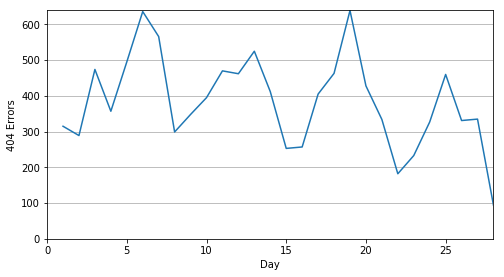

In [56]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(days_with_404_errors), 0, max(number_of_404_errors_on_day)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(days_with_404_errors, number_of_404_errors_on_day)
pass

### (4g) Exercise: Top Five Days for 404 Response Codes 
#### Using the RDD  dailyCounts you cached in the part (4e), what are the top five days for 404 response codes and the corresponding counts of 404 response codes?

In [58]:
top_five_days_for_404 = dailyCounts.takeOrdered(5, lambda x: -1*x[1])
print(top_five_days_for_404)

[(19, 639), (6, 636), (7, 566), (13, 525), (5, 495)]


### (4h) Exercise: Hourly 404 Response Codes
#### Using the RDD records_404 you cached in the part (4a) and by hour of the day and in increasing order, create an RDD containing how many requests had a 404 return code for each hour of the day (midnight starts at 0). Cache the resulting RDD hourRecordsSorted and print that as a list.

In [62]:
response_404_by_hour = records_404.map(lambda log: (log.date_time.hour, 1)).reduceByKey(lambda a,b: a+b)
response_404_by_hour = response_404_by_hour.sortByKey().cache()
print(response_404_by_hour.collect())

[(0, 428), (1, 320), (2, 268), (3, 240), (4, 167), (5, 146), (6, 134), (7, 239), (8, 363), (9, 480), (10, 589), (11, 728), (12, 650), (13, 530), (14, 750), (15, 831), (16, 630), (17, 617), (18, 498), (19, 410), (20, 381), (21, 442), (22, 483), (23, 460)]


### (4i) Exercise: Visualizing the 404 Response Codes by Hour
#### Using the results from the previous exercise, use matplotlib to plot a "Line" or "Bar" graph of the 404 response codes by hour.

In [65]:
hour_with_error_codes_404 = response_404_by_hour.map(lambda x: x[0]).collect()
number_of_404_error_codes_by_hour = response_404_by_hour.map(lambda x: x[1]).collect()

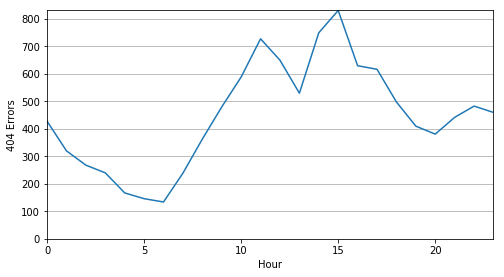

In [66]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(hour_with_error_codes_404), 0, max(number_of_404_error_codes_by_hour)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Hour')
plt.ylabel('404 Errors')
plt.plot(hour_with_error_codes_404, number_of_404_error_codes_by_hour)
pass